# Article Title:
## Explainable Machine Learning Prediction For Traffic Congestion During COVID-19 Using Human Mobility and Street-Waste Features

The Figures are for the article under submission titled Explainable Machine Learning Prediction For Traffic Congestion During COVID-19 Using Human Mobility and Street-Waste Features. Please refer the article for more details. 

In [1]:
# Author: Negin Zarbakhsh

In [14]:
import os
import holidays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
from scipy.stats import randint as sp_randint
import random
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
random.seed(44)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import lightgbm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import lightgbm
import shap
from scipy import stats
import scipy.stats as sp
from sklearn import linear_model 
from sklearn.svm import SVR
np.warnings.filterwarnings('ignore')
from scipy.stats import norm, skew

In [15]:
# Set the aesthetic style of the plots    
sns.set()
sns.set_style("whitegrid")
sns.set_style('ticks')
color = sns.color_palette("Paired")

## Defining Functions For Plottings

In [17]:
#Visualization of Train & Test Split (Start & End for zooming)
def plot_split (timesteps, values, format = ".", start = 0 , end = None, color =None, label =None):   

    plt.plot(timesteps[start:end], values[start:end],format, color = color, label=label)
    
    plt.ylabel("Traffic congestion (%)")
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.legend(fontsize = 12)
    plt.savefig('split.png', dpi=40, bbox_inches='tight')
# Plot for Feature importance
def plot_features (columns, importances, n=10):
    df = (pd.DataFrame({"features": columns,
                      "feature_importances": importances})
          .sort_values("feature_importances", ascending = False)
          .reset_index(drop = True))
    #plot
    fig, ax = plt.subplots(figsize=[5,7])

    ax.barh(df["features"][:n],
           df["feature_importances"][:n], color ='seagreen' )
    ax.set_ylabel ("Features")
    ax.set_xlabel("Features importance RF")
    ax.invert_yaxis()
    
    fig.savefig('rfeatureimportance.png',
            format='png',
            dpi=1800,
            bbox_inches='tight')
    fig.savefig('rfeatureimportance.pdf',
            format='pdf',
            dpi=1800,
            bbox_inches='tight')

## Importing Clean Data

In [16]:
#Reading file an~d date indeing
df = pd.read_csv('/content/Agreegated_Data.csv', parse_dates=['date'], index_col= 'date')
df = df.reset_index()
#Create Time-Related Features
df['Month'] = df.date.dt.month
df['Year'] = df.date.dt.year
df = df.set_index(df.date, drop =True)
df.drop(['date', 'Month'], inplace = True, axis = 1)
# Holidays in Ireland
df['Holiday'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('Ireland').get(x)).values
df['Holiday'] = df['Holiday'].astype('bool').astype('int')
# We slected cotegoric features for one-hot encoding
df= pd.get_dummies(df, columns=['Holiday'])
df = df.drop(['Year', 'Day'], axis = 1)

In [21]:
#Period
print ('Period of study %', - (df.index.min()- df.index.max()))
df.index.min(), df.index.max()

Period of study % 655 days 00:00:00


(Timestamp('2020-03-07 00:00:00'), Timestamp('2021-12-22 00:00:00'))

# Machine Learning Models

### A) Seprating Predictors From Target

In [23]:
#Target & Feature Defination
predictors = df.columns.drop('congestion')
target = df["congestion"]

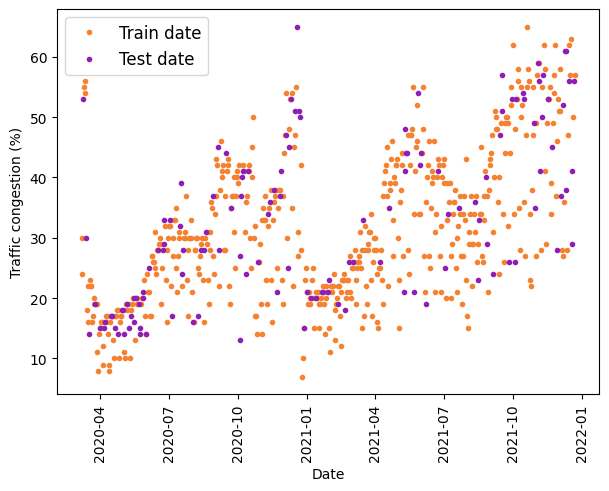

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[predictors], target, test_size=0.2, random_state=42)
plt.figure(figsize = (7,5))
plot_split(timesteps=X_train.index, values=y_train,  color ="#f58231",  label = 'Train date')
plot_split(timesteps=X_test.index, values=y_test,  color ="#911eb4",  label = 'Test date')

In [25]:
# Scaling Datasets
scaler = StandardScaler()
scaler.fit(X_train[predictors])  # Fit on Train Data
X_train[predictors] = scaler.transform(X_train[predictors])
X_test[predictors] = scaler.transform(X_test[predictors]) # Only Transfer on Test

## B) Defining Evaluation Metrics

In [26]:
# Function for MAPE Calculation
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train[predictors], y_train)
    y_pred = model.predict(X_test[predictors])
    
    # Printing Evaluation Metrics:
    print ('MSE', mean_squared_error(y_test,y_pred))
    print ('RMSE', np.sqrt(mean_squared_error(y_test,y_pred)))
    print ('MAE', mean_absolute_error (y_test,y_pred))
    print ('MAPE', mape (y_test,y_pred))
    print ('R2', r2_score(y_test,y_pred)*100)

    return model_name + '($R2={:.2f}$)'.format(r2_score(y_test,y_pred)*100), np.array(y_test), y_pred

## C) Model Implementation With best Hyper-Parameters

In [16]:
# Multiple Linear Regression
mlr = LinearRegression()
#RF & LGB
rf = RandomForestRegressor(n_jobs=-1, random_state=42) 
lg = lightgbm.LGBMRegressor(n_jobs=-1, random_state=42)
#SVR with two Kernals
svr_rbf = SVR(kernel='rbf', gamma=0.1)
tuned_svr_rbf = SVR(kernel= 'rbf', gamma = 0.01, epsilon = 0.5, C = 1000)

#### Hyper Parameter Tunning

In [ ]:
%%time
# HyperParameter for svr
param_grid = { 'C':[0.001, 0.01, 0.1, 1, 5, 10, 50, 0.1,1,100,1000],'kernel':['linear', 'rbf'],'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'epsilon':[0.1,0.2,0.5,0.3]}
#Nested cross validatio to only split based on train and test and not using validation set as data is not enough
tuned_svr = GridSearchCV(SVR(), param_grid= param_grid )
tuned_svr.fit(X_train, y_train)   
# HyperParameter for LightGBM
parameters = {'max_depth'     : [6,7,8,9,10,11,12,13,14,15],
              'learning_rate' : [0.01, 0.05, 0.1],
              'num_iteration' : [1000, 5000, 10000],
              'n_estimators'  : [100,300,500]
              # Add more parameters here for tuning
              }        
tuned_lgb = RandomizedSearchCV(lg,  param_distributions = parameters, cv = 5, 
                    verbose = 1, n_jobs = -1, refit = True)
tuned_lgb.fit(X_train, y_train) 


CPU times: user 13min 32s, sys: 463 ms, total: 13min 33s
Wall time: 13min 46s


In [22]:
results = []
print ('--------------------------------')
print ('Multiple Linear Regression')
print ('--------------------------------')
results.append(model('MLR', mlr, X_train, y_train, X_test, y_test))
print ('--------------------------------')
print ('RF')
print ('--------------------------------')
results.append(model('RF', rf, X_train, y_train, X_test, y_test))
print ('--------------------------------')
print ('LGB')
print ('--------------------------------')
results.append(model('LGB', lg, X_train, y_train, X_test, y_test))
print ('--------------------------------')
print ('SVR - RBF')
print ('--------------------------------')
results.append(model('SVR - RBF', svr_rbf, X_train, y_train, X_test, y_test))
print ('--------------------------------')
print ('Tuned SVR - RBF')
print ('--------------------------------')
results.append(model('Tuned SVR - RBF', tuned_svr_rbf, X_train, y_train, X_test, y_test))

--------------------------------
Multiple Linear Regression
--------------------------------
MSE 43.17032732810125
RMSE 6.570413025685771
MAE 4.920222128477071
MAPE 16.116505810270944
R2 77.1532288199607
--------------------------------
RF
--------------------------------
MSE 17.065220454545454
RMSE 4.131007196138183
MAE 2.5931060606060607
MAPE 8.606184412393295
R2 90.96867661209195
--------------------------------
LGB
--------------------------------
MSE 20.42144171425849
RMSE 4.519008930535376
MAE 2.8126916781047617
MAPE 9.35291241351275
R2 89.19248393772385
--------------------------------
SVR - RBF
--------------------------------
MSE 79.52168009555868
RMSE 8.91749292657744
MAE 6.193832140524777
MAPE 18.034270860036933
R2 57.91522229638319
--------------------------------
Tuned SVR - RBF
--------------------------------
MSE 15.307300212311768
RMSE 3.9124544997113726
MAE 2.835737426817326
MAPE 8.649598401721125
R2 91.89901010763923


# K-Fold Cross Validation

In [24]:
 # We  'kf'(KFold splitting stratergy) object as input to cross_val_score() method
from sklearn.model_selection import KFold
kf =KFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(df[predictors], target):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 524, Test set:132
Fold:2, Train set: 525, Test set:131
Fold:3, Train set: 525, Test set:131
Fold:4, Train set: 525, Test set:131
Fold:5, Train set: 525, Test set:131


In [25]:
# define the pipeline
steps = list()
#steps.append(('scaler', StandardScaler())) # decision tree based model doesn't need 
steps .append(('model', RandomForestRegressor()))
pipeline = Pipeline(steps=steps )
# define the evaluation procedure
# evaluate the model using cross-validation
MSE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_squared_error" )
RMSE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_root_mean_squared_error" )
MAE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_absolute_error" )
MAPE= cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_absolute_percentage_error" )
R2 = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="r2" )
# report performance
print (f'MSE= {"{:.2f}".format((-1* MSE.mean()))}')
print (f'RMSE= {"{:.2f}".format((-1* RMSE.mean()))}')
print (f'MAE= {"{:.2f}".format((-1* MAE.mean()))}')
print (f'MAPE= {"{:.2f}".format((-1* MAPE.mean()))}')
print (f'R2= {"{:.2f}".format((1* R2.mean()))}')

MSE= 12.59
RMSE= 3.50
MAE= 2.46
MAPE= 0.09
R2= 0.92


In [26]:
# define the pipeline
steps = list()
steps.append(('scaler', StandardScaler())) # decision tree based model doesn't need 
steps .append(('model', SVR(kernel= 'rbf', gamma = 0.01, epsilon = 0.5, C = 1000)))
pipeline = Pipeline(steps=steps )
# define the evaluation procedure
# evaluate the model using cross-validation
MSE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_squared_error" )
RMSE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_root_mean_squared_error" )
MAE = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_absolute_error" )
MAPE= cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="neg_mean_absolute_percentage_error" )
R2 = cross_val_score(pipeline, df[predictors], target, cv= kf, scoring="r2" )
# report performance
print (f'MSE= {"{:.2f}".format((-1* MSE.mean()))}')
print (f'RMSE= {"{:.2f}".format((-1* RMSE.mean()))}')
print (f'MAE= {"{:.2f}".format((-1* MAE.mean()))}')
print (f'MAPE= {"{:.2f}".format((-1* MAPE.mean()))}')
print (f'R2= {"{:.2f}".format((1* R2.mean()))}')


MSE= 14.99
RMSE= 3.86
MAE= 2.64
MAPE= 0.09
R2= 0.90


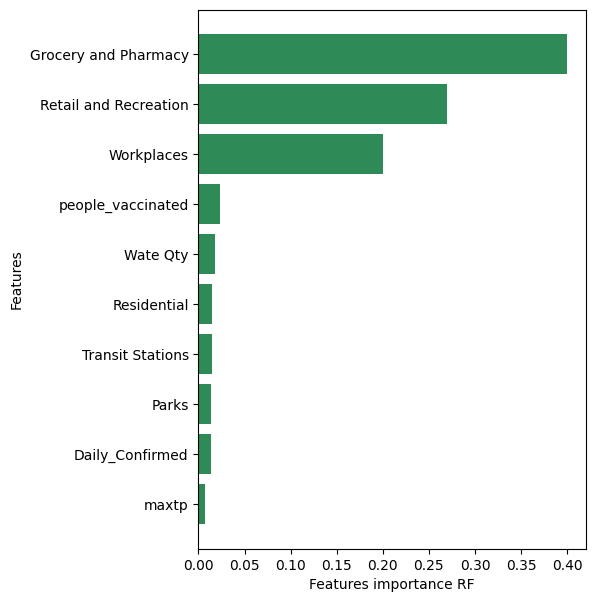

In [27]:
plot_features(X_train.columns,rf.feature_importances_ )

In [28]:
feature_scores_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

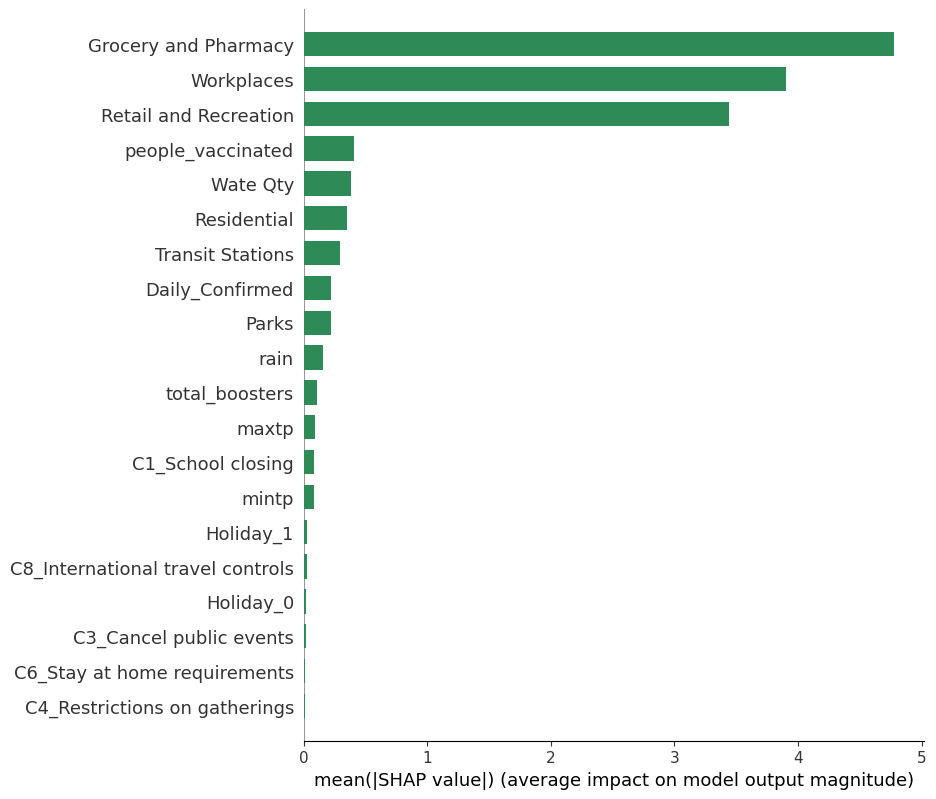

In [32]:
shap.initjs()
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", color = 'seagreen')

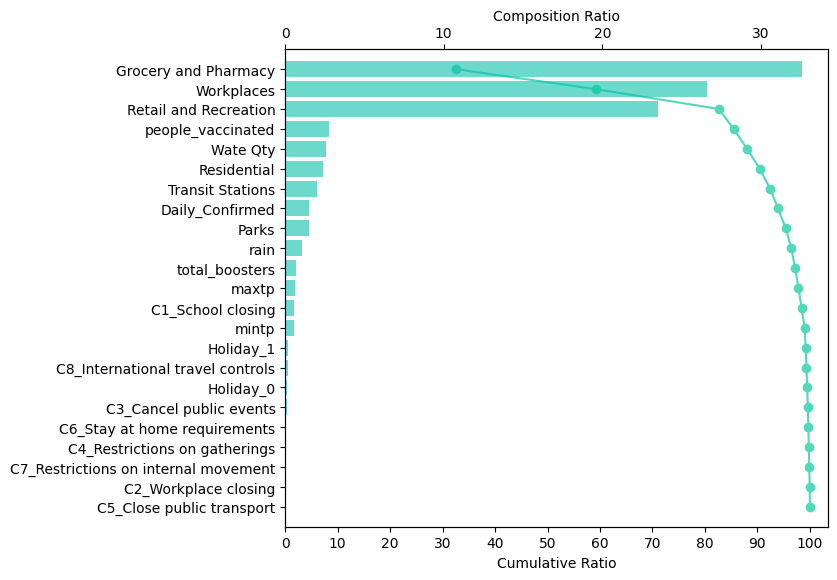

In [35]:
def make_shap_waterfall_plot(shap_values, features, num_display=25):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(7, 5 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='#53D8B9', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6, color = '#0CC0AB')
    
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
   # ax1.set_ylabel ('Sorted by Mean |SHAP Value|')
    ax1.tick_params(axis="y", labelsize=10)
    plt.ylim(-1, len(column_list))
    
    plt.savefig('SHAP.pdf', dpi=1800, bbox_inches='tight')
    plt.show()
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values, samples)